In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

In [2]:
# Import the preprocessed dataframes
train_raw_df = pd.read_csv("preprocessed_train(3).csv",
    dtype={'fullVisitorId': str}, nrows=None)
test_raw_df = pd.read_csv("preprocessed_test(3).csv",
    dtype={'fullVisitorId': str}, nrows=None)
train_raw_df.shape, test_raw_df.shape

((903653, 19), (804684, 18))

In [3]:
train_raw_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.continent,geoNetwork.country,geoNetwork.subContinent,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.medium,trafficSource.source
0,Organic Search,2016-09-02,1131660440785968503,1472830385,1,1472830385,Chrome,desktop,False,Windows,Asia,Turkey,Western Asia,1,1.0,1.0,0.0,organic,google
1,Organic Search,2016-09-02,377306020877927890,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,Oceania,Australia,Australasia,1,1.0,1.0,0.0,organic,google
2,Organic Search,2016-09-02,3895546263509774583,1472865386,1,1472865386,Chrome,desktop,False,Windows,Europe,Spain,Southern Europe,1,1.0,1.0,0.0,organic,google
3,Organic Search,2016-09-02,4763447161404445595,1472881213,1,1472881213,UC Browser,desktop,False,Linux,Asia,Indonesia,Southeast Asia,1,1.0,1.0,0.0,organic,google
4,Organic Search,2016-09-02,27294437909732085,1472822600,2,1472822600,Chrome,mobile,True,Android,Europe,United Kingdom,Northern Europe,1,0.0,1.0,0.0,organic,google


### Convert visitStartTime to different data features

In [4]:
def expand_visit_start_time(df):
    df['date'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour_of_day'] = df['date'].dt.hour
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.weekofyear
    
    # Drop date column
    df.drop(['date'], axis=1, inplace=True)
    return df

In [5]:
def apply_feature_engineering(df):
    df = expand_visit_start_time(df)
    return df

### Checkpoint

In [6]:
train_df = apply_feature_engineering(train_raw_df)
test_df = apply_feature_engineering(test_raw_df)

### String categorical features to lower case and Label Encoding

In [7]:
string_features = ['channelGrouping', 'device.browser', 'device.deviceCategory',
                   'device.operatingSystem', 'geoNetwork.continent', 'geoNetwork.country',
                   'geoNetwork.subContinent','trafficSource.medium', 'trafficSource.source']

for col in string_features:
    train_df[col] = train_df[col].str.lower()
    test_df[col] = test_df[col].str.lower()

In [8]:
train_df.head()

,channelGrouping,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.continent,...,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.medium,trafficSource.source,day_of_week,hour_of_day,day_of_month,week_of_year
0,organic search,1131660440785968503,1472830385,1,1472830385,chrome,desktop,False,windows,asia,...,1,1.0,1.0,0.0,organic,google,4,15,2,35
1,organic search,377306020877927890,1472880147,1,1472880147,firefox,desktop,False,macintosh,oceania,...,1,1.0,1.0,0.0,organic,google,5,5,3,35
2,organic search,3895546263509774583,1472865386,1,1472865386,chrome,desktop,False,windows,europe,...,1,1.0,1.0,0.0,organic,google,5,1,3,35
3,organic search,4763447161404445595,1472881213,1,1472881213,uc browser,desktop,False,linux,asia,...,1,1.0,1.0,0.0,organic,google,5,5,3,35
4,organic search,27294437909732085,1472822600,2,1472822600,chrome,mobile,True,android,europe,...,1,0.0,1.0,0.0,organic,google,4,13,2,35


In [9]:
from sklearn import preprocessing

for col in string_features:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

channelGrouping
device.browser
device.deviceCategory
device.operatingSystem
geoNetwork.continent
geoNetwork.country
geoNetwork.subContinent
trafficSource.medium
trafficSource.source


In [10]:
train_df.head()

,channelGrouping,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.continent,...,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.medium,trafficSource.source,day_of_week,hour_of_day,day_of_month,week_of_year
0,4,1131660440785968503,1472830385,1,1472830385,38,0,False,21,3,...,1,1.0,1.0,0.0,4,207,4,15,2,35
1,4,377306020877927890,1472880147,1,1472880147,56,0,False,8,5,...,1,1.0,1.0,0.0,4,207,5,5,3,35
2,4,3895546263509774583,1472865386,1,1472865386,38,0,False,21,4,...,1,1.0,1.0,0.0,4,207,5,1,3,35
3,4,4763447161404445595,1472881213,1,1472881213,114,0,False,7,3,...,1,1.0,1.0,0.0,4,207,5,5,3,35
4,4,27294437909732085,1472822600,2,1472822600,38,1,True,1,4,...,1,0.0,1.0,0.0,4,207,4,13,2,35


### Numerical variables conversion

In [11]:
num_features = ['totals.hits', 'totals.pageviews', 'visitNumber', 
                'totals.newVisits']

for col in num_features:
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].astype(int)

### Feature raniking with Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

temp_df = train_df.drop(['totals.transactionRevenue', 'fullVisitorId', 'visitStartTime', 'visitId'], axis=1)
temp_y = np.log1p(train_df['totals.transactionRevenue'].values)

model = RandomForestRegressor(n_jobs = -1,
                             random_state = seed)

model.fit(temp_df, temp_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=202, verbose=0, warm_start=False)

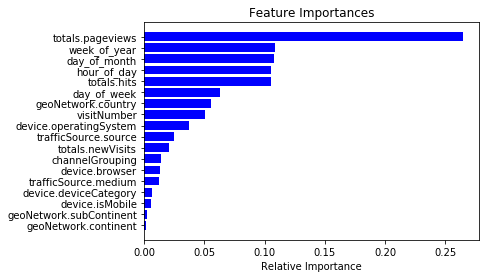

In [23]:
features = temp_df.columns
importances = model.feature_importances_
indices = np.argsort(importances[0:20])  # top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Export Dataframes

In [17]:
train_df.to_csv('featured_train(4).csv', index = False)
test_df.to_csv('featured_test(4).csv', index = False)